## **Stroke Risk Prediction with Basic ML (Logistic Regression & Random Forest)**

# 🩺 AI for Stroke Risk Prediction

## About this project
Stroke remains one of the leading causes of death and long-term disability worldwide. 
Early detection of individuals at high risk of stroke is critical for prevention and timely medical intervention.
This project explores how **machine learning** can be applied to predict stroke risk based on patient health records.

Using a publicly available dataset downloaded on Kaggle, the workflow includes.
- Data cleaning and exploratory analysis to understand patterns and correlations.
- Building and evaluating predictive models (Logistic Regression, Random Forest, etc.).
- Visualizing key trends and model performance to highlight which health factors most strongly influence stroke risk.

The aim is to show how data-driven approaches can support healthcare decision-making.
While this project is an academic exercise, it demonstrates the potential of AI to provide insights that could help reduce the global burden of stroke.

### **Step 1: Imports & basic config**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay)
import joblib

#### **Load Stroke Data Set downloaded from Kaggle. (stroke.csv)**

In [10]:
stroke_data = pd.read_csv("stroke.csv")
print(stroke_data.shape)
stroke_data.head()

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### **Step 2: Quick sanity checks & class balance**

In [24]:
# Target is 'stroke' (0/1)
print(df['stroke'].value_counts(normalize=True).rename('share'))

stroke
0    0.951272
1    0.048728
Name: share, dtype: float64


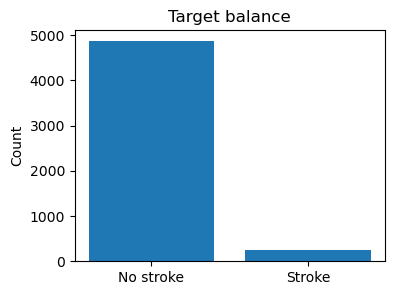

In [26]:
# Optional: quick bar plot of class balance
counts = df['stroke'].value_counts()
plt.figure(figsize=(4,3))
plt.bar(['No stroke','Stroke'], counts.values)
plt.title('Target balance')
plt.ylabel('Count')
plt.show()


In [28]:
# Look at missing values
stroke_data.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Note: The dataset is imbalanced (few stroke cases). We’ll handle this with class_weight='balanced'.

### **Step 3: Define features & preprocessing**

In [37]:
# Keep the common columns from the Kaggle dataset
# (If the CSV differs, adjust the list below)
feature_cols = [
    'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
    'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status'
]
target_col = 'stroke'

data = df[feature_cols + [target_col]].copy()

# Split
X = data[feature_cols]
y = data[target_col]

# Identify column types
num_cols = ['age', 'avg_glucose_level', 'bmi']
cat_cols = ['gender', 'hypertension', 'heart_disease', 'ever_married',
            'work_type', 'Residence_type', 'smoking_status']


### **Preprocessor:**

In [43]:
# - Numeric: median impute + (optionally) scale (useful for Logistic Regression)
# - Categorical: most_frequent impute + one-hot encode (ignore unknowns at inference)
numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, num_cols),
        ('cat', categorical_pipe, cat_cols)
    ]
)

### **Correlation heatmap (numeric features)**

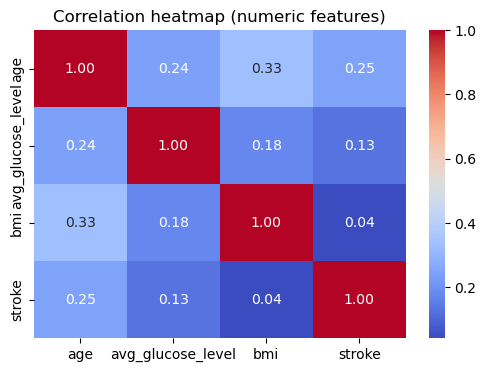

In [82]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.heatmap(df[num_cols + [target_col]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation heatmap (numeric features)")
plt.show()

### **Stroke risk by age group**

/var/folders/kg/byxgvbps7x9bt8nz0y7_2l_h0000gn/T/ipykernel_97636/3298877524.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stroke_rate = df.groupby('age_group')['stroke'].mean()


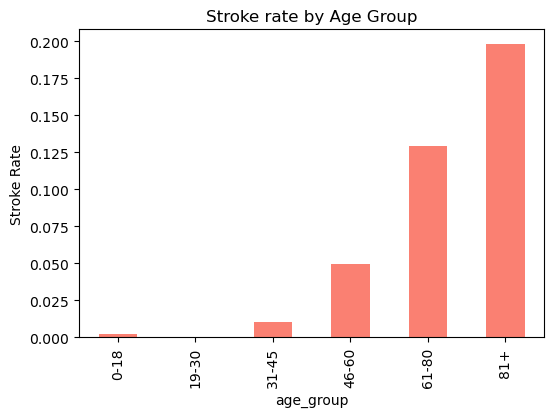

In [89]:
df['age_group'] = pd.cut(df['age'], bins=[0,18,30,45,60,80,100], 
                         labels=['0-18','19-30','31-45','46-60','61-80','81+'])

stroke_rate = df.groupby('age_group')['stroke'].mean()

plt.figure(figsize=(6,4))
stroke_rate.plot(kind='bar', color='salmon')
plt.ylabel("Stroke Rate")
plt.title("Stroke rate by Age Group")
plt.show()

### **Step 4: Train/test split (stratified)**

In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # keep class ratio similar in train/test
)

### **Step 5: Two simple models**

#### **5a) Logistic Regression (great baseline)**

In [54]:
log_reg = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=None))
])

log_reg.fit(X_train, y_train)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]
y_pred_lr = (y_prob_lr >= 0.5).astype(int)  # simple threshold; you can tune this

lr_scores = {
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr, zero_division=0),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1': f1_score(y_test, y_pred_lr),
    'ROC_AUC': roc_auc_score(y_test, y_prob_lr)
}
print("Logistic Regression:", {k: round(v, 3) for k, v in lr_scores.items()})

Logistic Regression: {'Accuracy': 0.747, 'Precision': 0.138, 'Recall': 0.8, 'F1': 0.236, 'ROC_AUC': 0.844}


#### **5b) Random Forest (handles non-linearities, robust)**

In [58]:
rf = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight='balanced_subsample',
        n_jobs=-1
    ))
])

rf.fit(X_train, y_train)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_prob_rf >= 0.5).astype(int)

rf_scores = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf, zero_division=0),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1': f1_score(y_test, y_pred_rf),
    'ROC_AUC': roc_auc_score(y_test, y_prob_rf)
}
print("Random Forest:", {k: round(v, 3) for k, v in rf_scores.items()})

Random Forest: {'Accuracy': 0.95, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0, 'ROC_AUC': 0.783}


### **Step 6:  Confusion matrix & ROC curve (simple visuals)**

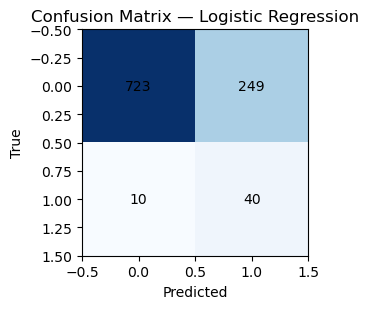

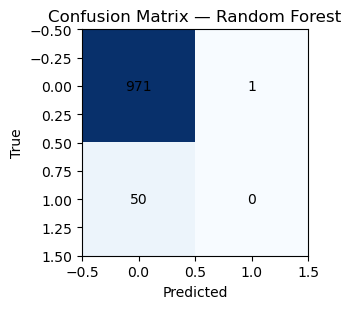

In [61]:
def show_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(3.8,3.2))
    plt.imshow(cm, cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted'); plt.ylabel('True')
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.tight_layout()
    plt.show()

show_confusion(y_test, y_pred_lr, "Confusion Matrix — Logistic Regression")
show_confusion(y_test, y_pred_rf, "Confusion Matrix — Random Forest")

<Figure size 450x350 with 0 Axes>

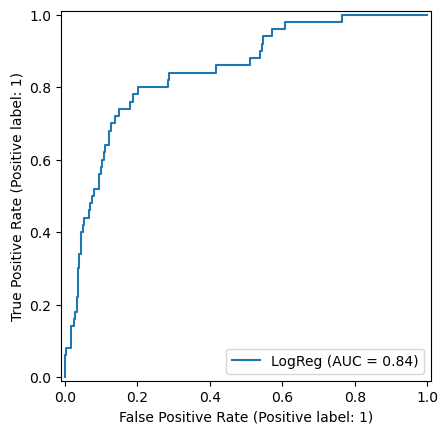

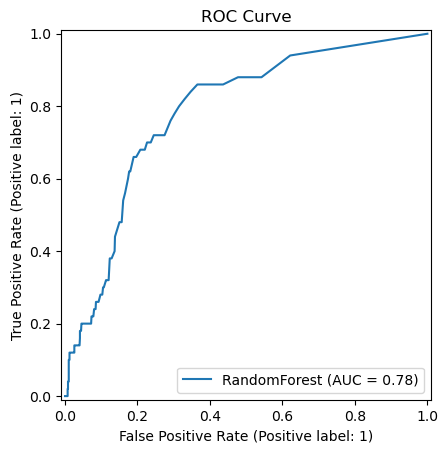

In [63]:
# ROC curves
plt.figure(figsize=(4.5,3.5))
RocCurveDisplay.from_predictions(y_test, y_prob_lr, name="LogReg")
RocCurveDisplay.from_predictions(y_test, y_prob_rf, name="RandomForest")
plt.title("ROC Curve")
plt.show()

### **Step 7: Quick feature importance (Random Forest)**

In [68]:
# Get feature names after preprocessing
ohe = rf.named_steps['prep'].named_transformers_['cat'].named_steps['ohe']
num_names = num_cols
cat_names = ohe.get_feature_names_out(cat_cols).tolist()
all_names = num_names + cat_names

importances = rf.named_steps['clf'].feature_importances_
top_idx = np.argsort(importances)[::-1][:10]

print("Top 10 features (RF):")
for i in top_idx:
    print(f"{all_names[i]:30s}  {importances[i]:.3f}")

Top 10 features (RF):
age                             0.356
avg_glucose_level               0.180
bmi                             0.166
ever_married_No                 0.027
ever_married_Yes                0.022
hypertension_0                  0.021
hypertension_1                  0.019
smoking_status_never smoked     0.019
work_type_Self-employed         0.018
work_type_Private               0.016


#### **Simple bar plot**

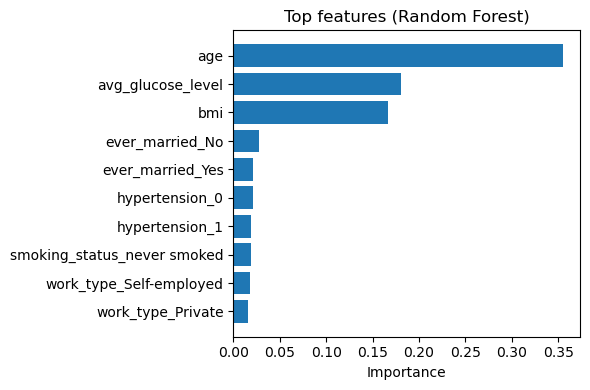

In [70]:
plt.figure(figsize=(6,4))
plt.barh([all_names[i] for i in top_idx][::-1],
         importances[top_idx][::-1])
plt.title("Top features (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

### **Step 8: Save the better model & run a demo prediction**

Choose the model with higher ROC-AUC (usually RF on this dataset). Save it.

In [74]:
best_model = rf  # or log_reg
joblib.dump(best_model, "stroke_model.joblib")
print("Saved model to stroke_model.joblib")

Saved model to stroke_model.joblib


Demo prediction (fill with realistic values):

In [80]:
example_person = pd.DataFrame([{
    'gender': 'Male',
    'age': 58.0,
    'hypertension': 1,
    'heart_disease': 0,
    'ever_married': 'Yes',
    'work_type': 'Private',          # 'Private','Self-employed','Govt_job','children','Never_worked'
    'Residence_type': 'Urban',       # 'Urban' or 'Rural'
    'avg_glucose_level': 140.5,
    'bmi': 29.3,
    'smoking_status': 'formerly smoked'  # 'never smoked','formerly smoked','smokes','Unknown'
}])

loaded = joblib.load("stroke_model.joblib")
risk_prob = loaded.predict_proba(example_person)[:,1][0]
print(f"Estimated stroke risk (probability): {risk_prob:.3f}")

Estimated stroke risk (probability): 0.080


### **Feature distributions for stroke vs non-stroke**

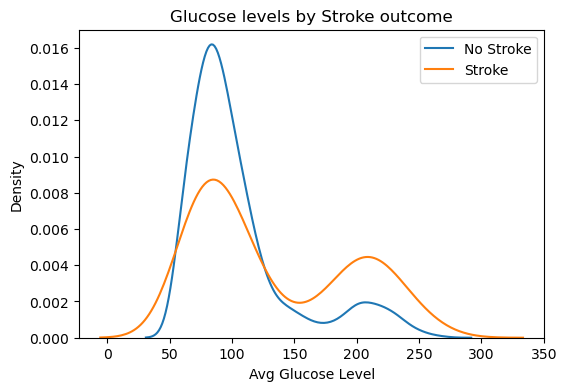

In [97]:
plt.figure(figsize=(6,4))
sns.kdeplot(df[df['stroke']==0]['avg_glucose_level'], label='No Stroke')
sns.kdeplot(df[df['stroke']==1]['avg_glucose_level'], label='Stroke')
plt.title("Glucose levels by Stroke outcome")
plt.xlabel("Avg Glucose Level")
plt.legend()
plt.show()

### **Precision-Recall curve**

<Figure size 450x350 with 0 Axes>

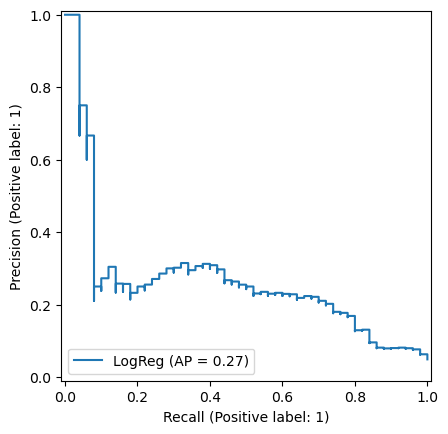

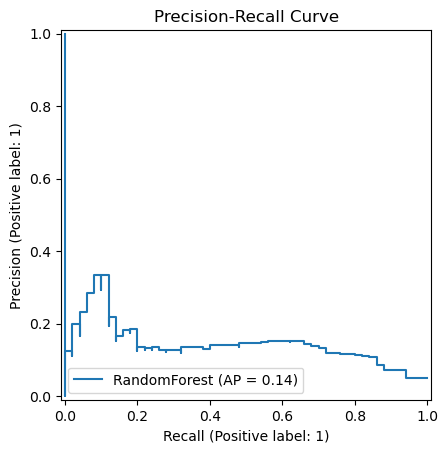

In [100]:
from sklearn.metrics import PrecisionRecallDisplay

plt.figure(figsize=(4.5,3.5))
PrecisionRecallDisplay.from_predictions(y_test, y_prob_lr, name="LogReg")
PrecisionRecallDisplay.from_predictions(y_test, y_prob_rf, name="RandomForest")
plt.title("Precision-Recall Curve")
plt.show()